###**0.Installing Dependencies and Importing Data**

In [ ]:
! pip install kaggle


In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [ ]:
!pip install tensorflow pandas matplotlib

In [ ]:
!pip install scikit-learn



In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np


In [ ]:
df= pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

###**1. Preprocessing**

In [ ]:
!pip list


In [ ]:
from tensorflow.keras.layers import TextVectorization


In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)


In [ ]:
vectorizer.get_vocabulary()

In [ ]:
vectorized_text = vectorizer(X.values)


In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks


In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
print(len(test))
print(len(train))

997
6981


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))  # 6 final o/p labels

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()
# Its bidirectional, so 64 and not 32


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)


6981/6981 [==============================] - 846s 120ms/step - loss: 0.0657 - val_loss: 0.0468


In [ ]:
from matplotlib import pyplot as plt


<Figure size 800x500 with 0 Axes>

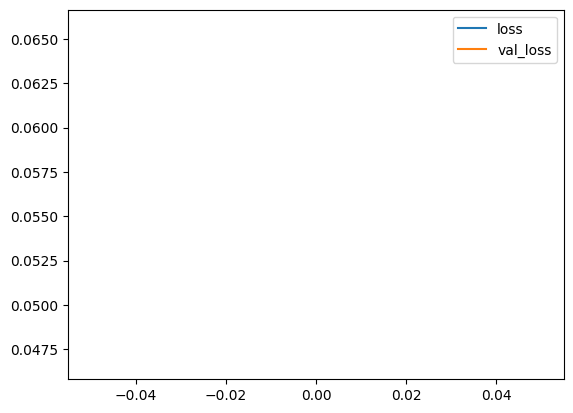

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

**Make Prediction**

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')


In [ ]:
res = model.predict(np.expand_dims(input_text,0))


1/1 [==============================] - 1s 797ms/step


In [ ]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 52ms/step


array([[0.97638243, 0.18243651, 0.83461696, 0.05106505, 0.69399446,
        0.15584302]], dtype=float32)

In [ ]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 59ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
res.shape

(1, 6)

**Evaluation of the Model**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X_true,y_true = batch
  yhat=model.predict(X_true)

  y_true=y_true.flatten()
  yhat=yhat.flatten()

  pre.update_state(y_true,yhat)
  re.update_state(y_true,yhat)
  acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 52ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.796723484992981, Recall:0.6917271614074707, Accuracy:0.4934804439544678


In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')


In [ ]:
input_str = vectorizer('hey i freaken hate you!')


In [ ]:
res = model.predict(np.expand_dims(input_str,0))


In [ ]:
res

In [ ]:
!pip install kaleido cohere openai tiktoken typing-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 7.0.1
    Uninstalling importlib-metadata-7.0.1:
      Successfully uninstalled importlib-metadata-7.0.1


In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')


In [ ]:
interface.launch(share=True)